<a href="https://colab.research.google.com/github/Marko-Vuchko/ml-category-prediction/blob/main/notebook/ML_Category_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kreiranje modela za predikciju kategorija proizvoda
**Autor:** *Marko Vučković*

## 🎯 Cilj:
***Cilj ovog zadatka bi bio razvoj modela mašinskog učenja koji će automatski predlagati odgovarajuću kategoriju za svaki novi proizvod na osnovu njegovog naziva.***

## **📚 Biblioteke:**

*Vršimo uvoz neophodnih biblioteka koje su nam potrebne za ovaj projekat.*

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## **🔑 Uvoz podataka:**
*Uvozimo skup podataka, ispisujemo broj redova i kolona, prikazujemo prvih nekoliko redova i na kraju prikazujemo tipove podataka u kolonama, kao i da li postoje NaN vrednosti.*

In [12]:
# Učitavanje skupa podataka sa GutHub-a
url = "https://raw.githubusercontent.com/Marko-Vuchko/ml-category-prediction/main/data/products.csv"

df = pd.read_csv(url)

# Ispisivanje broja redova i kolona
print("Dataset shape (rows, columns):", df.shape)

# Ispisivanje prvih 5 redova
print("\nFirst 5 rows:")
display(df.head())

# Prikaz tipova podataka kolona i NaN vrednosti
print("\nDataset info:")
df.info()

Dataset shape (rows, columns): (35311, 8)

First 5 rows:


,product ID,Product Title,Merchant ID,Category Label,_Product Code,Number_of_Views,Merchant Rating,Listing Date
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.0,2.5,5/10/2024
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.0,4.8,12/31/2024
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,Mobile Phones,FP-8086-IE,3092.0,3.9,11/10/2024
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.0,3.4,5/2/2022
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,Mobile Phones,NZ-3586-WP,4426.0,1.6,4/12/2023



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       35311 non-null  int64  
 1   Product Title    35139 non-null  object 
 2   Merchant ID      35311 non-null  int64  
 3    Category Label  35267 non-null  object 
 4   _Product Code    35216 non-null  object 
 5   Number_of_Views  35297 non-null  float64
 6   Merchant Rating  35141 non-null  float64
 7    Listing Date    35252 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.2+ MB


## **🧮 Nedostajuće vrednosti:**
*Računamo broj nedostajućih vrednosti po kolonama, i vršimo grafički prikaz rasprostranjenosti takvih vrednosti.*

Missing values per column:
product ID           0
Product Title      172
Merchant ID          0
 Category Label     44
_Product Code       95
Number_of_Views     14
Merchant Rating    170
 Listing Date       59
dtype: int64


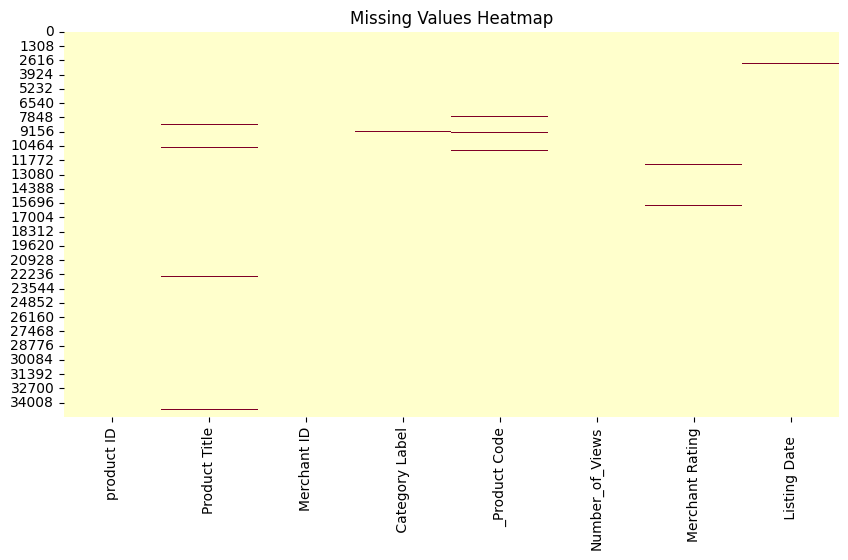

In [13]:
# Brojanje nedostajućih vrednosti po kolonama
print("Missing values per column:")
print(df.isna().sum())

# Grafički prikaz nedostajućih vrednosti
plt.figure(figsize=(10, 5))
sns.heatmap(df.isna(), cbar=False, cmap="YlOrRd")
plt.title("Missing Values Heatmap")
plt.show()

## **🛠️ Uređivanje kolona:**
*Standardizujemo kolone tako što ih sve pretvaramo u mala slova, uklanjamo razmake, kao i nepotrebne simbole. Takođe u ovom delu izvršićemo i brisanje NaN vrednosti.*

In [14]:
# Standardizacija imena kolona
df.columns = (df.columns.str.lower().str.strip().str.replace("_", " ").str.replace(" ", "_").str.lstrip("_"))
print("\nColumn names after standardization:")
df.columns

# Brisanje redova sa NaN vrednostima
df = df.dropna()

# Prikazivanje nove veličine skupa podataka
print("New dataset shape:", df.shape)

# Provera nedostajućih vrednosti nakon brisanja
print("Missing values per column:")
print(df.isna().sum())


Column names after standardization:
New dataset shape: (34760, 8)
Missing values per column:
product_id         0
product_title      0
merchant_id        0
category_label     0
product_code       0
number_of_views    0
merchant_rating    0
listing_date       0
dtype: int64


## **🔎 Ispitivanje kolone "category_label":**
*Ispitaćemo kolonu "category_label" da bi utvrdili jedinstvene vrednosti u koloni, a da bi nam bilo lakše da uočimo razlike izvršićemo i grafički prikaz takvih vrednosti.*


Unique values in 'category_label' column:
category_label
Fridge Freezers     5424
Washing Machines    3971
Mobile Phones       3970
CPUs                3711
TVs                 3502
Fridges             3403
Dishwashers         3374
Digital Cameras     2661
Microwaves          2307
Freezers            2182
fridge               121
CPU                   81
Mobile Phone          53
Name: count, dtype: int64


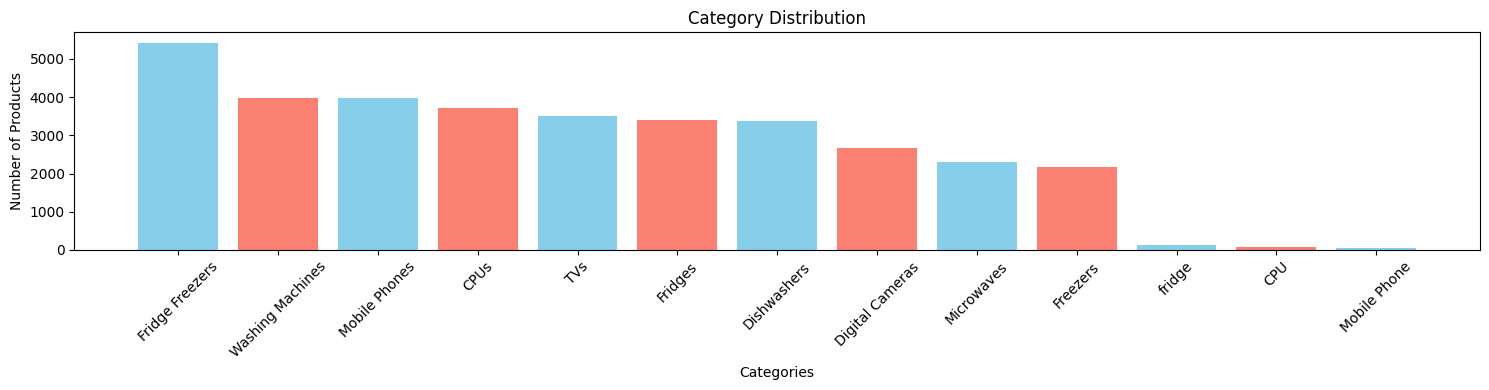

In [15]:
# Prikaz jedinstvenih vrednosti u koloni 'category_label'
print("\nUnique values in 'category_label' column:")
category_counts = df['category_label'].value_counts()
print(category_counts)

# Grafički prikaz distribucije kategorija
plt.figure(figsize=(15, 4))
plt.bar(category_counts.index, category_counts.values, color=['skyblue', 'salmon'])
plt.title("Category Distribution")
plt.xlabel("Categories")
plt.ylabel("Number of Products")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **🧹 Standardizacija kolone "category_label":**
*Standardizujemo kolonu "category_label" na mala slova i uklanjamo razmake. Vršimo objedinjavanje više naziva jedne kategorije u isključivo jedan naziv. Takođe, vrišmo konvertovanje tipa kolone u tip "category".*

In [16]:
# Konvertovanje kolone 'category_label' u string, pretvaranje u mala slova i uklanjanje razmaka
df["category_label"] = df["category_label"].astype(str).str.lower().str.strip()

# Mapiranje nepravilnih vrednosti na ispravne
df["category_label"] = df["category_label"].replace({"fridges": "fridge", "mobile phones": "mobile phone", "fridge freezers": "freezers","cpus": "cpu"})

# Prikaz jedinstvenih vrednosti nakon čišćenja
print("Unique category values after cleaning:")
print(df["category_label"].value_counts())

# Konvertovanje kolone 'category_label' u kategorijski tip podataka
df["category_label"] = df["category_label"].astype("category")
print("\nData types after conversion:",  df["category_label"].dtype)

Unique category values after cleaning:
category_label
freezers            7606
mobile phone        4023
washing machines    3971
cpu                 3792
fridge              3524
tvs                 3502
dishwashers         3374
digital cameras     2661
microwaves          2307
Name: count, dtype: int64

Data types after conversion: category


## **🔬 Analiza kolone "product_title":**
*Brojimo reči u naslovu, brojimo karaktere u naslovu, proveravamo prosečnu dužinu reči, tražimo najdužu reč, ispitujemo da li postoje skraćenice u naslovu i na kraju utvrđujemo da li postoje interpukcijski znakovi i reči napisane velikim slovom u naslovu.*

In [17]:
# Broj reči u naslovu
word_count = df['product_title'].str.split().str.len()
print(f'Max words in title: {word_count.max()}')
print(f'Min words in title: {word_count.min()}')

# Broj karaktera u naslovu
char_count = df['product_title'].str.len()
print(f'\nMax characters in title: {char_count.max()}')
print(f'Min characters in title: {char_count.min()}')

# Prosečna dužina reči
avg_word_length = df['product_title'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
print(f'\nAverage word length in title(in charachters): {avg_word_length.mean():.2f}')

# Dužina najduže reči
longest_word_length = df['product_title'].apply(lambda x: max([len(word) for word in str(x).split()]))
print(f'\nLongest word length in title(in charachters): {longest_word_length.max()}\n')

# Prisutnost čestih skraćenica
common_terms = ['USB', 'LED', 'HD', 'LCD', 'PC', 'TV']
for term in common_terms:
    broj_pojavljivanja = df['product_title'].str.contains(term, case=False).sum()
    print(f'Abbreviation {term} appears in {broj_pojavljivanja} titles')

# Broj reči napisanih velikim slovima
uppercase_words = df['product_title'].apply(lambda x: sum(word.isupper() for word in str(x).split()))
print(f'\nMean uppercase words in title: {uppercase_words.mean()}')

# Broj interpunkcijskih znakova
punct_count = df['product_title'].str.count('[,.-]')
print(f"\nMean punctuation count in title: {punct_count.mean():.2f}")

Max words in title: 37
Min words in title: 1

Max characters in title: 200
Min characters in title: 5

Average word length in title(in charachters): 5.59

Longest word length in title(in charachters): 33

Abbreviation USB appears in 77 titles
Abbreviation LED appears in 2232 titles
Abbreviation HD appears in 2663 titles
Abbreviation LCD appears in 283 titles
Abbreviation PC appears in 67 titles
Abbreviation TV appears in 2774 titles

Mean uppercase words in title: 0.0

Mean punctuation count in title: 0.20


## **🗑️ Uklanjanje kolona:**
*Uklanjamo kolone koje nam nisu potrebne za treniranje modela.*

In [18]:
# Uklanjanje kolona koje nisu potrebne za treniranje modela
df = df.drop(columns=["product_id", "merchant_id", "product_code", "merchant_rating", "listing_date"])

# Pregled preostalih kolona
print("Remaining columns:")
print(df.columns.tolist())

Remaining columns:
['product_title', 'category_label', 'number_of_views']


## **📝 Priprema podataka za treniranje modela:**
*Kreiramo promenljive sa kolonama koje će nam biti potrebne za treniranje modela, a zatim vršimo podelu na skup podataka za treniranje i testiranje modela. Na kraju vršimo preprocesiranje, odnosno prevođenje na jezik razumljiv mašini.*

In [19]:
# Karakteristike i oznake
X = df[["product_title", "number_of_views"]]
y = df["category_label"]

# Train-test podela
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocesiranje podataka
preprocessor = ColumnTransformer(
    transformers=[
        ("title", TfidfVectorizer(), "product_title"),
        ("views", MinMaxScaler(), ["number_of_views"])
    ]
)

## **🤖 Modeli:**
*Kreiramo rečnik sa modelima koje ćemo trenirati i kasnije testirati da bi uočili koji model nam najviše odgovara za ovaj projekat.*


🔎 Logistic Regression

Accuracy: 0.9600115074798619

Confusion Matrix:
 [[ 754    0    0    2    0    0    1    1    0]
 [   0  528    0    1    0    0    2    1    0]
 [   0    0  647   20    2    0    1    0    5]
 [   0    0   15 1464   29    2    0    2    9]
 [   0    0    7   70  621    0    1    1    5]
 [   0    0    4   13    4  436    0    1    3]
 [   0    0    0    1    1    0  798    5    0]
 [   0    1    0    7    0    0    7  686    0]
 [   0    0   16   27    1    1    1    8  740]]


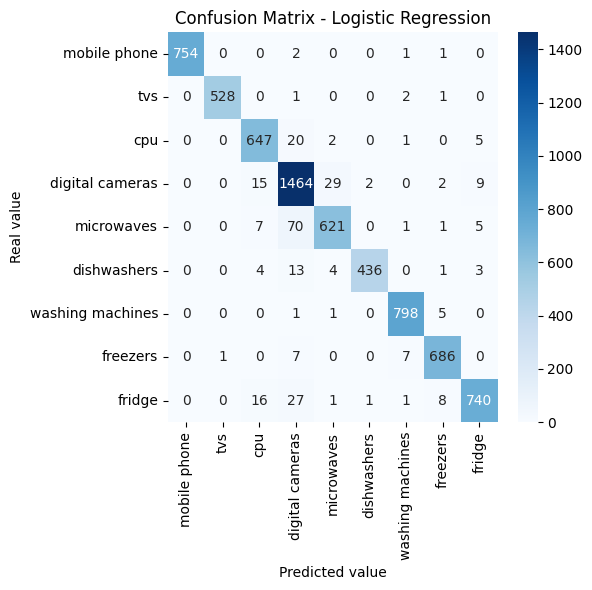

                  precision    recall  f1-score   support

             cpu       1.00      0.99      1.00       758
 digital cameras       1.00      0.99      1.00       532
     dishwashers       0.94      0.96      0.95       675
        freezers       0.91      0.96      0.94      1521
          fridge       0.94      0.88      0.91       705
      microwaves       0.99      0.95      0.97       461
    mobile phone       0.98      0.99      0.99       805
             tvs       0.97      0.98      0.98       701
washing machines       0.97      0.93      0.95       794

        accuracy                           0.96      6952
       macro avg       0.97      0.96      0.96      6952
    weighted avg       0.96      0.96      0.96      6952

----------------------------------------------------------------------------------------------------

🔎 Naive Bayes

Accuracy: 0.9310989643268124

Confusion Matrix:
 [[ 755    0    0    2    0    0    0    1    0]
 [   0  529    0    1    0   

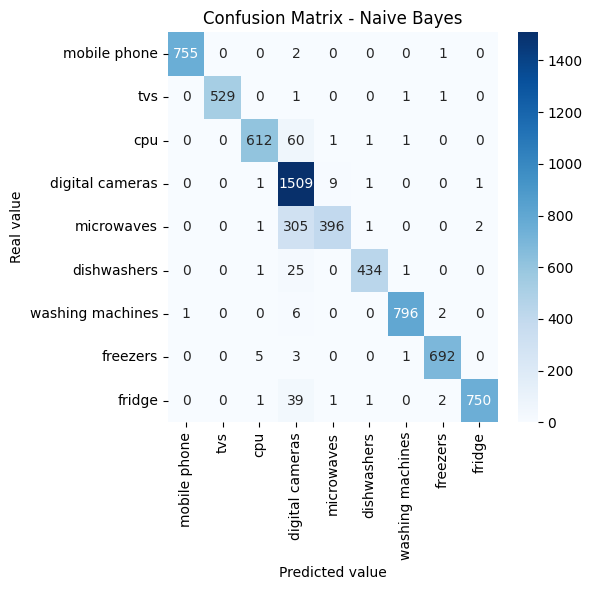

                  precision    recall  f1-score   support

             cpu       1.00      1.00      1.00       758
 digital cameras       1.00      0.99      1.00       532
     dishwashers       0.99      0.91      0.94       675
        freezers       0.77      0.99      0.87      1521
          fridge       0.97      0.56      0.71       705
      microwaves       0.99      0.94      0.97       461
    mobile phone       0.99      0.99      0.99       805
             tvs       0.99      0.99      0.99       701
washing machines       1.00      0.94      0.97       794

        accuracy                           0.93      6952
       macro avg       0.97      0.92      0.94      6952
    weighted avg       0.94      0.93      0.93      6952

----------------------------------------------------------------------------------------------------

🔎 Decision Tree

Accuracy: 0.9400172612197929

Confusion Matrix:
 [[ 754    0    0    0    0    0    4    0    0]
 [   0  510    0    1    0 

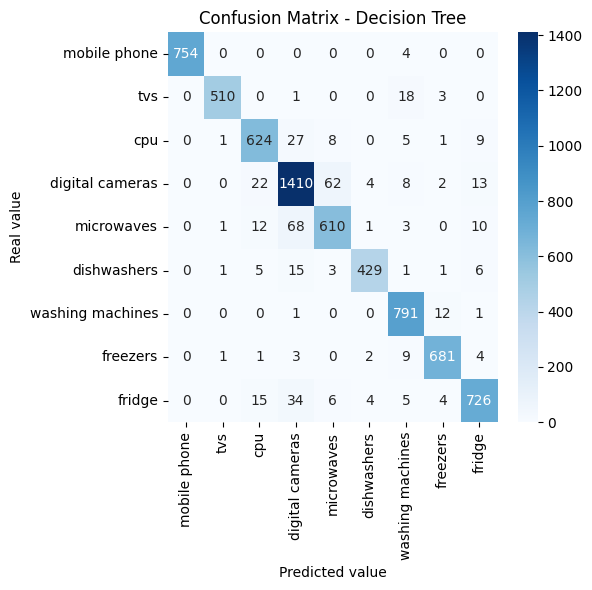

                  precision    recall  f1-score   support

             cpu       1.00      0.99      1.00       758
 digital cameras       0.99      0.96      0.98       532
     dishwashers       0.92      0.92      0.92       675
        freezers       0.90      0.93      0.92      1521
          fridge       0.89      0.87      0.88       705
      microwaves       0.97      0.93      0.95       461
    mobile phone       0.94      0.98      0.96       805
             tvs       0.97      0.97      0.97       701
washing machines       0.94      0.91      0.93       794

        accuracy                           0.94      6952
       macro avg       0.95      0.94      0.94      6952
    weighted avg       0.94      0.94      0.94      6952

----------------------------------------------------------------------------------------------------

🔎 Random Forest

Accuracy: 0.9591484464902187

Confusion Matrix:
 [[ 756    0    0    2    0    0    0    0    0]
 [   0  524    0    3    0 

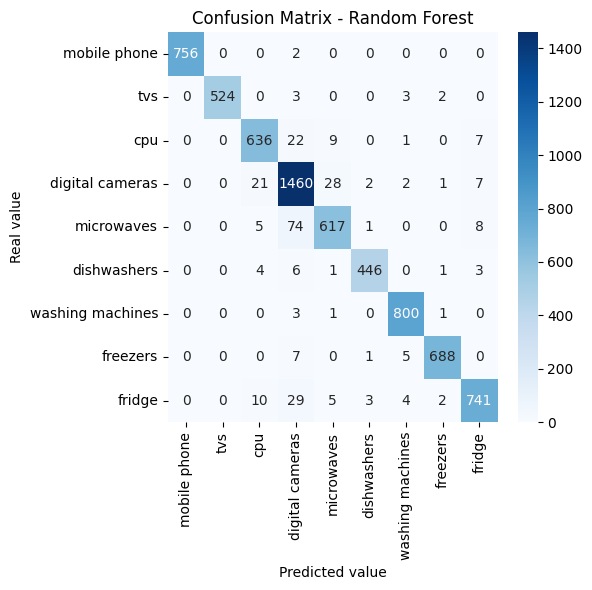

                  precision    recall  f1-score   support

             cpu       1.00      1.00      1.00       758
 digital cameras       1.00      0.98      0.99       532
     dishwashers       0.94      0.94      0.94       675
        freezers       0.91      0.96      0.93      1521
          fridge       0.93      0.88      0.90       705
      microwaves       0.98      0.97      0.98       461
    mobile phone       0.98      0.99      0.99       805
             tvs       0.99      0.98      0.99       701
washing machines       0.97      0.93      0.95       794

        accuracy                           0.96      6952
       macro avg       0.97      0.96      0.96      6952
    weighted avg       0.96      0.96      0.96      6952

----------------------------------------------------------------------------------------------------

🔎 Support Vector Machine

Accuracy: 0.9706559263521288

Confusion Matrix:
 [[ 756    0    0    0    0    0    2    0    0]
 [   0  530    0  

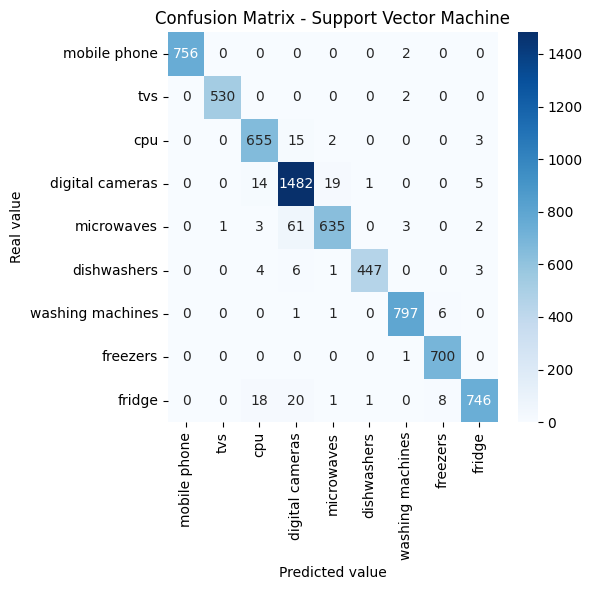

                  precision    recall  f1-score   support

             cpu       1.00      1.00      1.00       758
 digital cameras       1.00      1.00      1.00       532
     dishwashers       0.94      0.97      0.96       675
        freezers       0.94      0.97      0.95      1521
          fridge       0.96      0.90      0.93       705
      microwaves       1.00      0.97      0.98       461
    mobile phone       0.99      0.99      0.99       805
             tvs       0.98      1.00      0.99       701
washing machines       0.98      0.94      0.96       794

        accuracy                           0.97      6952
       macro avg       0.98      0.97      0.97      6952
    weighted avg       0.97      0.97      0.97      6952

----------------------------------------------------------------------------------------------------


In [20]:
# Modeli
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": LinearSVC()
}

# Treniranje i evaluacija modela
for name, model in models.items():
    print(f"\n🔎 {name}")
    pipeline = Pipeline([
       ["preprocessing", preprocessor],
       ["classifier", model]
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Kreiranje confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Vizualizacija confusion matrix-a
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=y.unique(),
                yticklabels=y.unique())

    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel("Real value")
    plt.xlabel("Predicted value")

    plt.tight_layout()
    plt.show()

    print(classification_report(y_test, y_pred))
    print("-" * 100)
